# Udacity Deep Learning Project - Digit Recognition - Part 2 - Digit Recognizer

Author: Lei Mao <br>
Late revised on: 12/29/2016 <br>

Notes: Try using grayed SVHN data here. Replace a large receptive field convolutional layer with a stack of very small convolutional filters.

## Convolutional Neural Network (CNN) for SVHN Dataset

### Import libraries required

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from six.moves import cPickle as pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
%autosave 0

Autosave disabled


### Load SVHN dataset

In [3]:
# Read training dataset
SVHN_folder = 'data/SVHN/'
pickle_file = 'train_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_train_dataset = save['dataset']
    SVHN_train_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN training set', SVHN_train_dataset.shape, SVHN_train_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN training set', (100206, 32, 32, 3), (100206, 6))


In [4]:
# Read extra_0 dataset
SVHN_folder = 'data/SVHN/'
pickle_file = 'extra_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_extra_dataset = save['dataset']
    SVHN_extra_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN extra set', SVHN_extra_dataset.shape, SVHN_extra_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN extra set', (607059, 32, 32, 3), (607059, 6))


In [5]:
SVHN_train_dataset = np.concatenate((SVHN_train_dataset, SVHN_extra_dataset), axis = 0)
del SVHN_extra_dataset
SVHN_train_labels = np.concatenate((SVHN_train_labels, SVHN_extra_labels), axis = 0)
del SVHN_extra_labels

In [6]:
# Read test dataset
SVHN_folder = 'data/SVHN/'
pickle_file = 'test_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    SVHN_test_dataset = save['dataset']
    SVHN_test_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN test set', SVHN_test_dataset.shape, SVHN_test_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN test set', (13068, 32, 32, 3), (13068, 6))


In [7]:
# Split test dataset to test and validation datasets
SVHN_test_dataset, SVHN_valid_dataset, SVHN_test_labels, SVHN_valid_labels = train_test_split(
    SVHN_test_dataset, SVHN_test_labels, test_size = 5./10, random_state = 0)

In [8]:
# Cut the label
length_limit = 5
SVHN_train_labels = SVHN_train_labels[:, 0: length_limit]
SVHN_valid_labels = SVHN_valid_labels[:, 0: length_limit]
SVHN_test_labels = SVHN_test_labels[:, 0: length_limit]

In [9]:
# Shuffle training set
SVHN_train_dataset, SVHN_train_labels = shuffle(SVHN_train_dataset, SVHN_train_labels, random_state = 0)

In [10]:
# Check the size of each dataset
print('Training set: %d images and %d labels.' %(len(SVHN_train_dataset), len(SVHN_train_labels)))
print('Validation set: %d images and %d labels.' %(len(SVHN_valid_dataset), len(SVHN_valid_labels)))
print('Test set: %d images and %d labels.' %(len(SVHN_test_dataset), len(SVHN_test_labels)))

Training set: 707265 images and 707265 labels.
Validation set: 6534 images and 6534 labels.
Test set: 6534 images and 6534 labels.


Reformat into a TensorFlow-friendly shape:
* convolutions need the image data formatted as a cube (width by height by #channels)
* labels as float 1-hot encodings.

In [11]:
num_length_class = length_limit + 2 # 0, 1, 2, 3, 4, 5, more than 5
num_digit_class = 11 # 0: blank, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 0
num_image_rows = 32
num_image_columns = 32
num_channels = 3

def onehot_encoding(array, num_class):
    '''Turn a numerical numpy array to one-hot encoded matrix'''
    onehot_encoded = np.zeros(shape=(len(array), num_class), dtype=np.int)
    for i in xrange(len(array)):
        onehot_encoded[i][array[i]] = 1
    return onehot_encoded

def labels_reformat(dataset, labels):
    '''Reformat dataset to [num_images, num_rows, num_columns, num_channels]'''
    '''Reformat labels to one-hot encoded matrix list'''
    dataset = dataset.reshape((-1, num_image_rows, num_image_columns, num_channels))
    labelset = list()
    length = np.sum(labels != 0, axis = 1)
    length_onehot = onehot_encoding(array = length, num_class = num_length_class)
    labelset.append(length_onehot)
    for i in xrange(labels.shape[1]):
        digit_onehot = onehot_encoding(array = labels[:, i], num_class = num_digit_class)
        labelset.append(digit_onehot)
    return dataset, labelset

In [12]:
train_dataset, train_labelset = labels_reformat(SVHN_train_dataset, SVHN_train_labels)
valid_dataset, valid_labelset = labels_reformat(SVHN_valid_dataset, SVHN_valid_labels)
test_dataset, test_labelset = labels_reformat(SVHN_test_dataset, SVHN_test_labels)

In [13]:
def image_grayed(dataset):
    dataset_grayed = np.zeros(shape = (dataset.shape[0], dataset.shape[1], dataset.shape[2], 1), dtype = int)
    for i in xrange(len(dataset)):
        for j in xrange(dataset.shape[3]):
            dataset_grayed[i, :, :, 0] += dataset[i, :, :, j]
        dataset_grayed[i] = dataset_grayed[i] // dataset.shape[3]
        # Normalize each image by subtracting its mean
        dataset_grayed[i, :, :, 0] = dataset_grayed[i, :, :, 0] - np.mean(dataset_grayed[i, :, :, 0])
    return dataset_grayed

In [14]:
# Gray all the datasets
train_dataset = image_grayed(train_dataset)
valid_dataset = image_grayed(valid_dataset)
test_dataset = image_grayed(test_dataset)

[ 2 10  0  0  0]


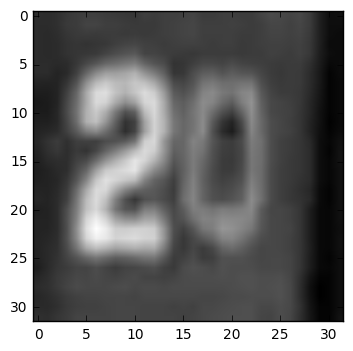

In [15]:
image_index = np.random.randint(len(train_dataset))
print(SVHN_train_labels[image_index])
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(train_dataset[image_index][:, :, 0], cmap ='gray')
plt.show()

### Build Deep Convolutional Neural Network using Tensorflow

In [16]:
def probabilities_to_label(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return np.array([c for c in np.argmax(probabilities, 1)])
def accuracy_type_1(prediction_digits, labels):
    digits_predicted = list()
    for i in xrange(len(prediction_digits)):
        digits_predicted.append(probabilities_to_label(prediction_digits[i]))
    labels_predicted = np.array(digits_predicted).T
    num_correct = 0
    #print(labels_predicted[0])
    #print(labels[0])
    for i in xrange(len(labels)):
        num_correct += np.array_equal(labels_predicted[i], labels[i])
    accuracy = float(num_correct)/len(labels)
    return accuracy
def accuracy_type_2(prediction_digits, labels):
    digits_predicted = list()
    for i in xrange(len(prediction_digits)):
        digits_predicted.append(probabilities_to_label(prediction_digits[i]))
    labels_predicted = np.array(digits_predicted).T
    num_correct = 0
    #print(labels_predicted[0])
    #print(labels[0])
    for i in xrange(len(labels)):
        num_correct += np.sum(labels_predicted[i] == labels[i])
    accuracy = float(num_correct)/(labels.shape[0] * labels.shape[1])
    return accuracy

2 layers of CNN

In [17]:
batch_size = 64
patch_size = 3
depth_1 = 16
depth_2 = 32
depth_3 = 64

num_hidden = 64
num_channels = 1
keep_prob = 0.8

#train_size = len(SVHN_train_labels)

graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_image_rows, num_image_columns, num_channels))
    tf_train_labelset = list()
    tf_train_labelset.append(tf.placeholder(tf.float32, shape=(batch_size, num_length_class)))
    for i in xrange(length_limit):
        tf_train_labelset.append(tf.placeholder(tf.float32, shape=(batch_size, num_digit_class)))
    
    tf_valid_dataset = tf.constant(valid_dataset, dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset, dtype=tf.float32)
    
    #keep_prob = tf.constant(0.8, dtype = tf.float32)

    # Variables
    cnn_1_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth_1], stddev=0.1), 
                                name = 'CNN_1_1_W')
    cnn_1_1_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_1_B')

    cnn_1_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_1], stddev=0.1), 
                                name = 'CNN_1_2_W')
    cnn_1_2_biases = tf.Variable(tf.zeros([depth_1]), name = 'CNN_1_2_B')    

    cnn_2_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_1, depth_2], stddev=0.1), 
                                name = 'CNN_2_1_W')
    cnn_2_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_1_B')

    cnn_2_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_2], stddev=0.1), 
                                name = 'CNN_2_2_W')
    cnn_2_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]), name = 'CNN_2_2_B')

    cnn_3_1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_2, depth_3], stddev=0.1), 
                                name = 'CNN_3_1_W')
    cnn_3_1_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_1_B')

    cnn_3_2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth_3, depth_3], stddev=0.1), 
                                name = 'CNN_3_2_W')
    cnn_3_2_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]), name = 'CNN_3_2_B')

    fc_1_weights = tf.Variable(tf.truncated_normal(
            [num_image_rows // 8 * num_image_columns // 8 * depth_3, num_hidden], stddev=0.1), name = 'FC_1_W')
    fc_1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name = 'FC_1_B')
    
    logistic_weights = list()
    logistic_biases = list()
    logistic_weights.append(tf.Variable(tf.truncated_normal([num_hidden, num_length_class], stddev=0.1), name = 'H0_W'))
    logistic_biases.append(tf.Variable(tf.zeros([num_length_class]), name = 'H0_B'))
    
    for i in xrange(length_limit):
        logistic_weights.append(tf.Variable(
                tf.truncated_normal([num_hidden, num_digit_class], stddev=0.1), name = 'H' + str(i + 1) + '_W'))
        logistic_biases.append(tf.Variable(tf.constant(1.0, shape=[num_digit_class]), name = 'H' + str(i + 1) + '_B'))

    # Model
    def model(data, keep_prob = keep_prob):
        
        conv = tf.nn.conv2d(data, cnn_1_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_1_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_1_2_biases)        
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        
        conv = tf.nn.conv2d(hidden, cnn_2_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_2_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_2_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        conv = tf.nn.conv2d(hidden, cnn_3_1_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_1_biases)
        conv = tf.nn.conv2d(hidden, cnn_3_2_weights, [1, 1, 1, 1], padding = 'SAME')
        hidden = tf.nn.relu(conv + cnn_3_2_biases)
        # local_response_normalization is very useful in this case
        hidden = tf.nn.local_response_normalization(hidden)
        hidden = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
        hidden = tf.nn.dropout(hidden, keep_prob = keep_prob)
        
        logits = list()
        for i in xrange(length_limit + 1):
            logits.append(tf.matmul(hidden, logistic_weights[i]) + logistic_biases[i])
        
        return logits
    '''
    # Training computation
    train_logits_dropout = model(tf_train_dataset, keep_prob = keep_prob)

    train_loss = 0
    for i in xrange(length_limit + 1):
        train_loss = train_loss + tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(train_logits_dropout[i], tf_train_labelset[i]))
    '''
    # Training computation
    train_logits_dropout = model(tf_train_dataset, keep_prob = keep_prob)

    train_loss = 0
    for i in xrange(length_limit):
        train_loss = train_loss + tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(train_logits_dropout[i + 1], tf_train_labelset[i + 1]))    

    # Optimizer
    #optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(train_loss)
    
    # Optimizer.
    global_step = tf.Variable(0)
    #learning rate with exponential decay.
    learning_rate = tf.train.exponential_decay(
        learning_rate = 0.05, global_step = global_step, decay_steps = 5000, decay_rate = 0.8, staircase = True) 
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(train_loss, global_step = global_step)
    
    
    # Optimizer.
    #batch = tf.Variable(0, dtype=tf.float32)
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    #learning_rate = tf.train.exponential_decay(0.01, batch * batch_size, train_size, 0.95, staircase=True)
    # Use simple momentum for the optimization.
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(train_loss, global_step=batch)

    # Predict the length of sequence in training set
    train_logits = model(tf_train_dataset, keep_prob = 1.0)
    train_prediction_length = tf.nn.softmax(train_logits[0])
    
    # Predict the digits of sequence in training set
    train_prediction_digits = list()
    for i in xrange(length_limit):
        train_prediction_digits.append(tf.nn.softmax(train_logits[i + 1]))
    train_prediction_digits = tf.pack(train_prediction_digits)
    
    # Predict the length of sequence in validation set
    valid_logits = model(tf_valid_dataset, keep_prob = 1.0)
    valid_prediction_length = tf.nn.softmax(valid_logits[0])
    
    # Predict the digits of sequence in validation set
    valid_prediction_digits = list()
    for i in xrange(length_limit):
        valid_prediction_digits.append(tf.nn.softmax(valid_logits[i + 1]))
    valid_prediction_digits = tf.pack(valid_prediction_digits)
    
    # Predict the length of sequence in test set
    test_logits = model(tf_test_dataset, keep_prob = 1.0)
    test_prediction_length = tf.nn.softmax(test_logits[0])
    
    # Predict the digits of sequence in test set
    test_prediction_digits = list()
    for i in xrange(length_limit):
        test_prediction_digits.append(tf.nn.softmax(test_logits[i + 1]))
    test_prediction_digits = tf.pack(test_prediction_digits)
    
    # Prediction of single test data
    # Input data
    tf_test_single = tf.placeholder(tf.float32, shape=(1, num_image_rows, num_image_columns, num_channels))
    # Predict the length of sequence in single test data
    test_logits_single = model(tf_test_single)
    test_prediction_length_single = tf.nn.softmax(test_logits_single[0])
    # Predict the digits of sequence in single test data
    test_prediction_digits_single = list()
    for i in xrange(length_limit):
        test_prediction_digits_single.append(tf.nn.softmax(test_logits_single[i + 1]))
    test_prediction_digits_single = tf.pack(test_prediction_digits_single)   
    
    saver = tf.train.Saver()

In [18]:
num_steps = 100001
model_path = 'model/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_dataset = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labelset = list()
        for i in xrange(len(train_labelset)):
            batch_labelset.append(train_labelset[i][offset:(offset + batch_size), :])
        feed_dict = {tf_train_dataset: batch_dataset}
        for i in xrange(len(train_labelset)):
            feed_dict[tf_train_labelset[i]] = batch_labelset[i]
        _, l, prediction_length, prediction_digits = session.run(
            [optimizer, train_loss, train_prediction_length, train_prediction_digits], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy type 1: %.1f%%' 
                  %(accuracy_type_1(prediction_digits = prediction_digits, 
                                    labels = SVHN_train_labels[offset:(offset + batch_size), :]) * 100))
            print('Minibatch accuracy type 2: %.1f%%' 
                  %(accuracy_type_2(prediction_digits = prediction_digits, 
                                    labels = SVHN_train_labels[offset:(offset + batch_size), :]) * 100))
        if (step % 500 == 0):
            print('=' * 40)
            print('Validation accuracy type 1: %.1f%%' 
                  %(accuracy_type_1(prediction_digits = valid_prediction_digits.eval(), 
                                    labels = SVHN_valid_labels) * 100))
            print('Validation accuracy type 2: %.1f%%' 
                  %(accuracy_type_2(prediction_digits = valid_prediction_digits.eval(), 
                                    labels = SVHN_valid_labels) * 100))
            print('=' * 40)
            
    print('Test accuracy type 1: %.1f%%' 
          %(accuracy_type_1(prediction_digits = test_prediction_digits.eval(), labels = SVHN_test_labels) * 100))
    print('Test accuracy type 2: %.1f%%' 
          %(accuracy_type_2(prediction_digits = test_prediction_digits.eval(), labels = SVHN_test_labels) * 100))
    save_path = saver.save(sess = session, save_path = model_path + 'CNN_SVHN')
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 14.590732
Minibatch accuracy type 1: 0.0%
Minibatch accuracy type 2: 24.1%
Validation accuracy type 1: 1.2%
Validation accuracy type 2: 63.5%
Minibatch loss at step 100: 6.965472
Minibatch accuracy type 1: 0.0%
Minibatch accuracy type 2: 54.7%
Minibatch loss at step 200: 6.806110
Minibatch accuracy type 1: 0.0%
Minibatch accuracy type 2: 53.8%
Minibatch loss at step 300: 6.919069
Minibatch accuracy type 1: 0.0%
Minibatch accuracy type 2: 55.6%
Minibatch loss at step 400: 7.054724
Minibatch accuracy type 1: 0.0%
Minibatch accuracy type 2: 53.1%
Minibatch loss at step 500: 6.753136
Minibatch accuracy type 1: 1.6%
Minibatch accuracy type 2: 56.6%
Validation accuracy type 1: 2.5%
Validation accuracy type 2: 64.1%
Minibatch loss at step 600: 6.417886
Minibatch accuracy type 1: 1.6%
Minibatch accuracy type 2: 57.5%
Minibatch loss at step 700: 6.732350
Minibatch accuracy type 1: 3.1%
Minibatch accuracy type 2: 55.6%
Minibatch loss at step 800: 6.113834
Mi